In [1]:
import tensorflow as tf
import time
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3136 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'random']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 3 0 1 1 1 1 2 1 3 0 0 3 0 1 2 3 3 3 0 0 0 3 1 3 1 3 3 0 2 0 3]


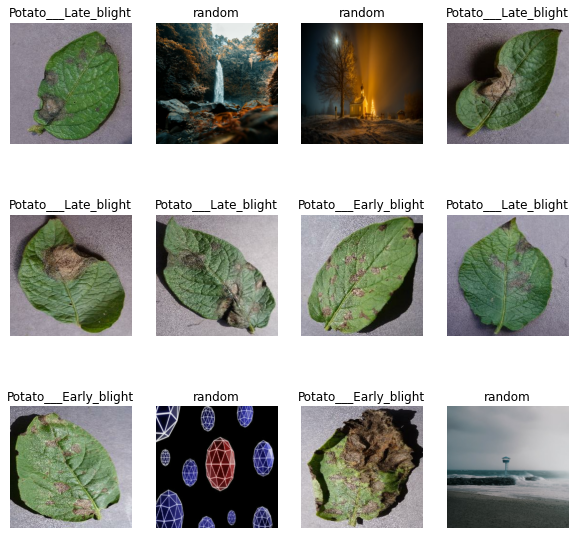

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

78.4

In [8]:
train_ds = dataset.take(78)

In [9]:
test_ds = dataset.skip(78)
len(test_ds)

20

In [10]:
val_size=0.1
len(dataset)*val_size

9.8

In [11]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [12]:
test_ds = test_ds.skip(10)
len(test_ds)

10

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
len(train_ds)


78

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Epoch 1/10
78/78 [==============================] - 78s 972ms/step - loss: 0.8828 - accuracy: 0.6006 - val_loss: 0.6074 - val_accuracy: 0.7437
Epoch 2/10
78/78 [==============================] - 76s 975ms/step - loss: 0.4967 - accuracy: 0.7957 - val_loss: 0.8224 - val_accuracy: 0.6250
Epoch 3/10
78/78 [==============================] - 80s 1s/step - loss: 0.2830 - accuracy: 0.8834 - val_loss: 0.3667 - val_accuracy: 0.8562
Epoch 4/10
78/78 [==============================] - 80s 1s/step - loss: 0.2048 - accuracy: 0.9239 - val_loss: 0.1976 - val_accuracy: 0.9125
Epoch 5/10
78/78 [==============================] - 81s 1s/step - loss: 0.2049 - accuracy: 0.9295 - val_loss: 0.1583 - val_accuracy: 0.9312
Epoch 6/10
78/78 [==============================] - 82s 1s/step - loss: 0.0914 - accuracy: 0.9732 - val_loss: 0.1279 - val_accuracy: 0.9531
Epoch 7/10
78/78 [==============================] - 81s 1s/step - loss: 0.0964 - accuracy: 0.9679 - val_loss: 0.7313 - val_accuracy: 0.7906
Epoch 8/10
78/

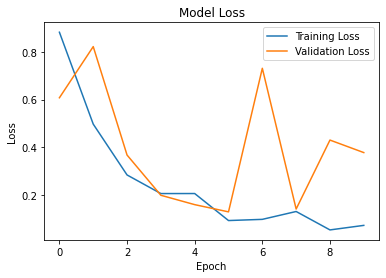

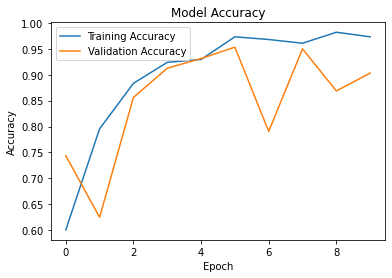

Time taken to train the model  806.6606211662292 seconds


In [22]:
start_time = time.time()

history1 = model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=10,)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy at each epoch
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
end_time = time.time()
print("Time taken to train the model ", end_time - start_time, "seconds")

1/1 [==============================] - 0s 257ms/step


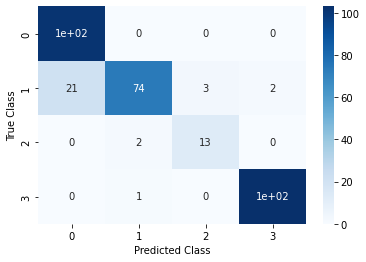

In [23]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_ds)

# Create a confusion matrix for the testing data
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(model.predict(x).argmax(axis=1))

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
import seaborn as sns

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


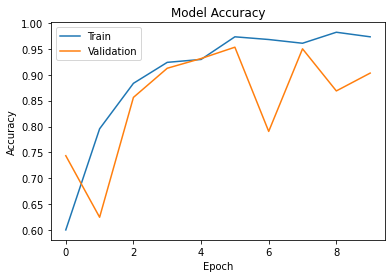

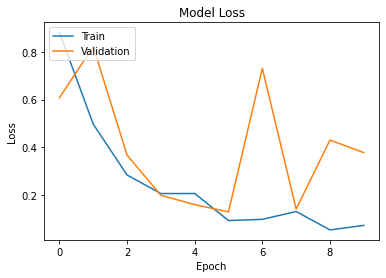

In [24]:
# Accuracy and loss curves
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [25]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 2s 224ms/step - loss: 0.2986 - accuracy: 0.9094


In [26]:
scores


[0.29862162470817566, 0.909375011920929]

In [27]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 241ms/step
predicted label: Potato___Early_blight


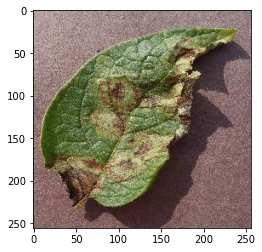

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 30ms/step


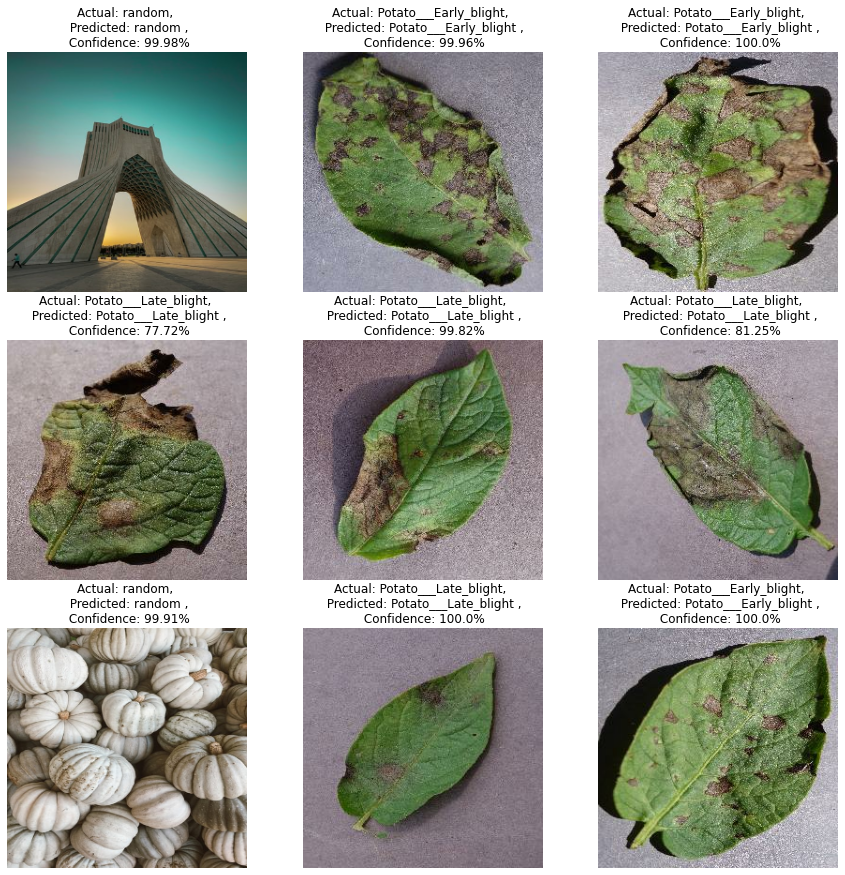

In [29]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} ,\n Confidence: {confidence}%")
        plt.axis("off")


In [30]:
dataset_1 = tf.keras.preprocessing.image_dataset_from_directory(
    "folder",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 12 files belonging to 1 classes.


1/1 [==============================] - 0s 25ms/step


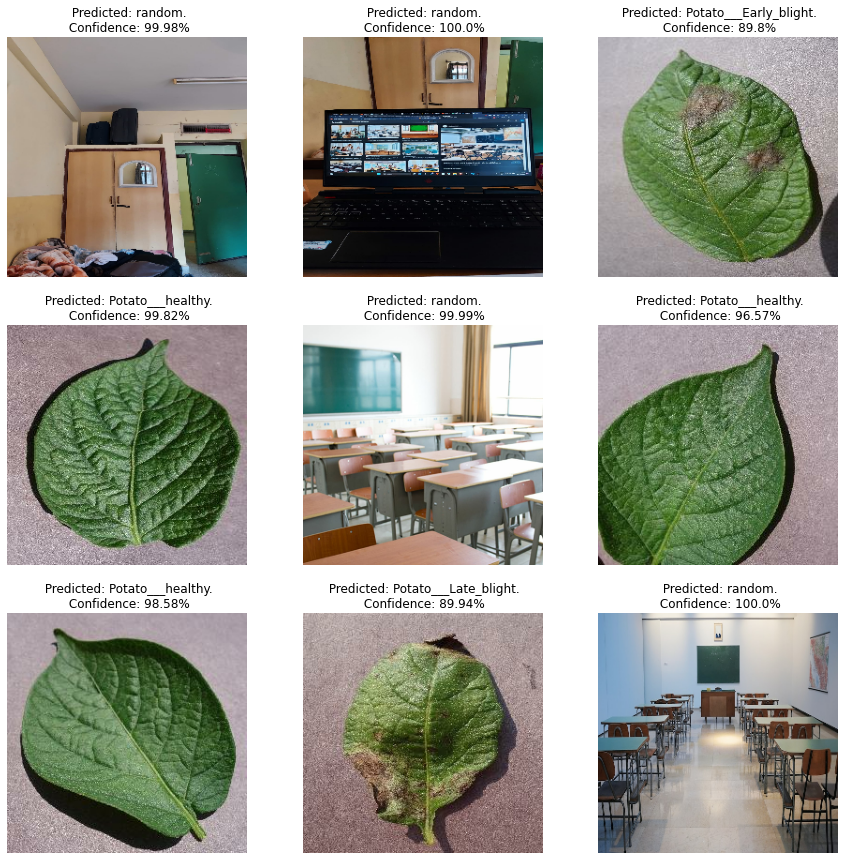

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in dataset_1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f" Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:
import os
model_version=1
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
